
--- Starting 'Rain-Fed' Scenario ---
dummy\dssat_rain-fed_run created.
🚀 Running simulation in: dummy\dssat_rain-fed_run

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1  70 125 12901  4722   279     0   376    97     0   -99      0  186

Summary Output (Evaluate.OUT):
{'flo': 70, 'mat': 125, 'topwt': 12901, 'harwt': 4722, 'rain': 279, 'tirr': 0, 'cet': 376, 'pesw': 97, 'tnup': 0, 'tnlf': None, 'tson': 0, 'tsoc': 186}

--- Starting 'Irrigated' Scenario ---
dummy\dssat_irrigated_run created.
🚀 Running simulation in: dummy\dssat_irrigated_run

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1  70 125 17659  8208   279   157   439   182     0   -99      0  186

Summary Output (Evaluate.OUT):
{'flo': 70, 'mat': 125, 'topwt': 17659, 'harwt': 8208, 'rain'

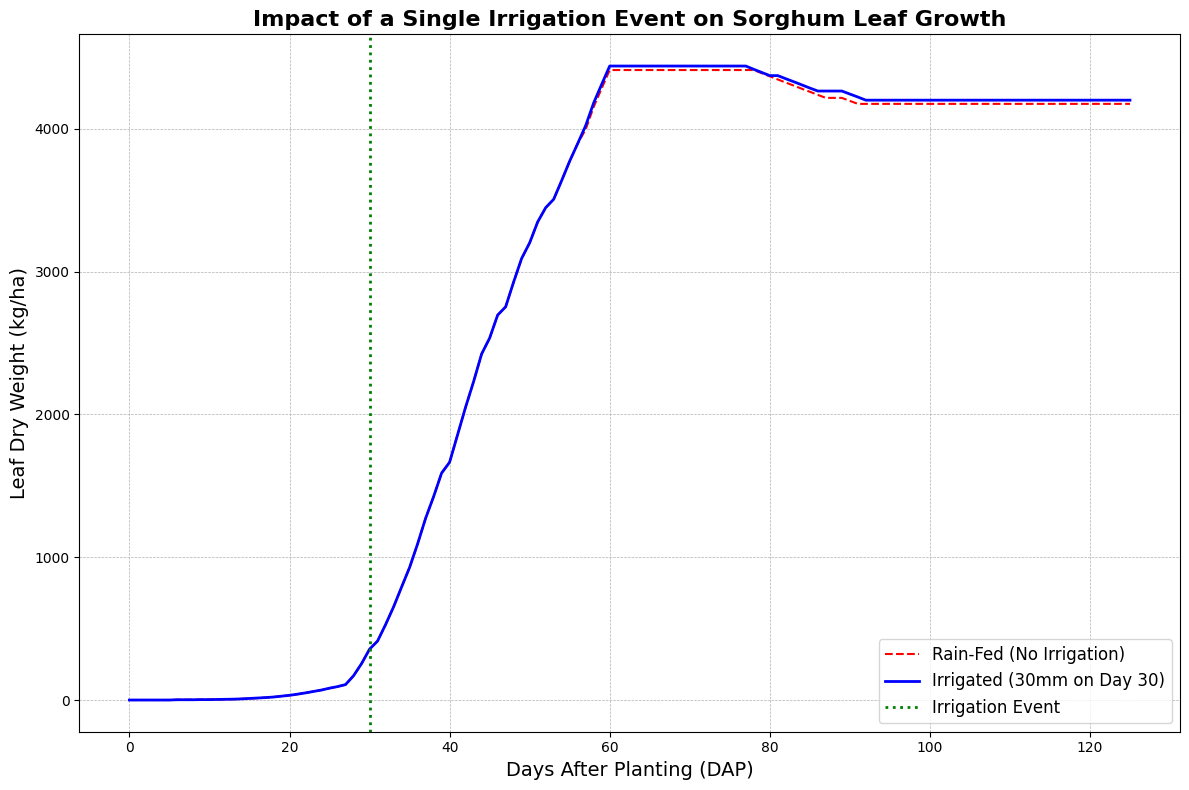

✅ Plot generated successfully.


In [11]:
# Irrigation Comparison and Visualization
from DSSATTools import (
    crop,
    WeatherStation,
    SoilProfile,
    filex,
    DSSAT
)
import pandas as pd
from datetime import datetime, timedelta
import os
import shutil
import matplotlib.pyplot as plt

# --- DEFINE FILE PATHS AND DATES ---
# Using a known-good weather file from the DSSAT examples for reliability
WEATHER_FILE_PATH = r"D:\Final-Year-Project\project-trail\defaults\Weather\ALCL5601.WTH" 
SOIL_FILE_PATH = "MY_GENERATED_SOIL.SOL"
SOIL_ID = "SG12387893"
PLANTING_DATE = datetime(1956, 6, 15) # Adjusted to match the weather file's year

# --- 1. SETUP ---
weather_station = WeatherStation.from_files([WEATHER_FILE_PATH])
soil_profile = SoilProfile.from_file(SOIL_ID, SOIL_FILE_PATH)
cultivar = crop.Sorghum('IB0026')

field = filex.Field(id_field='REALTIME', wsta=weather_station, id_soil=soil_profile)
planting = filex.Planting(pdate=PLANTING_DATE, ppop=18, ppoe=18, plrs=45, pldp=5)

soil_depths = [int(layer['slb']) for layer in soil_profile.table]
initial_values_table = [(depth, 0.35, 1.5, 1.5) for depth in soil_depths]
initial_conditions = filex.InitialConditions(
    pcr='SG', icdat=PLANTING_DATE, icres=1300, icren=0.5,
    table=pd.DataFrame(initial_values_table, columns=['icbl', 'sh2o', 'snh4', 'sno3'])
)

# --- 2. RUN SIMULATION SCENARIOS ---

# Dictionary to store the results of each run
simulation_outputs = {}

for scenario in ["Rain-Fed", "Irrigated"]:
    
    print(f"\n--- Starting '{scenario}' Scenario ---")

    simulation_controls = filex.SimulationControls(
        general=filex.SCGeneral(sdate=PLANTING_DATE),
        options=filex.SCOptions(water='Y', nitro='N', symbi='N'),
        methods=filex.SCMethods(infil='S'),
        management=filex.SCManagement(irrig='A' if scenario == "Irrigated" else 'N', ferti='N', resid='N', harvs='M')
    )

    irrigation = None
    if scenario == "Irrigated":
        irrigation_date = PLANTING_DATE + timedelta(days=30)
        irrigation_events = [
            filex.IrrigationEvent(idate=irrigation_date, irop='IR001', irval=30) # 30mm on Day 30
        ]
        irrigation = filex.Irrigation(table=irrigation_events)

    try:
        workspace = os.path.join("dummy", f"dssat_{scenario.lower()}_run")
        os.makedirs(workspace, exist_ok=True)
        
        shutil.copy(WEATHER_FILE_PATH, workspace)
        shutil.copy(SOIL_FILE_PATH, workspace)
        
        dssat = DSSAT(workspace)
        print(f"🚀 Running simulation in: {workspace}")
        
        run_args = {
            'field': field,
            'cultivar': cultivar,
            'planting': planting,
            'initial_conditions': initial_conditions,
            'simulation_controls': simulation_controls
        }
        if irrigation:
            run_args['irrigation'] = irrigation

        results = dssat.run_treatment(**run_args)
        
        print("\nSummary Output (Evaluate.OUT):")
        print(results)
        
        if 'PlantGro' in dssat.output_tables:
            simulation_outputs[scenario] = dssat.output_tables['PlantGro']

    except Exception as e:
        print(f"❌ An error occurred during the {scenario} run: {e}")


# --- 3. VISUALIZE THE RESULTS ---

if "Rain-Fed" in simulation_outputs and "Irrigated" in simulation_outputs:
    print("\n--- Generating Growth Comparison Plot ---")
    
    # Set the 'DAP' column as the index for both DataFrames for easy plotting
    rainfed_df = simulation_outputs["Rain-Fed"].set_index('DAP')
    irrigated_df = simulation_outputs["Irrigated"].set_index('DAP')
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot Leaf Weight (LWAD) for both scenarios
    rainfed_df['LWAD'].plot(label='Rain-Fed (No Irrigation)', color='red', linestyle='--')
    irrigated_df['LWAD'].plot(label='Irrigated (30mm on Day 30)', color='blue', linewidth=2)
    
    # Add a vertical line to show when the irrigation happened
    plt.axvline(x=30, color='green', linestyle=':', linewidth=2, label='Irrigation Event')
    
    # Add labels and title for clarity
    plt.xlabel("Days After Planting (DAP)", fontsize=14)
    plt.ylabel("Leaf Dry Weight (kg/ha)", fontsize=14)
    plt.title("Impact of a Single Irrigation Event on Sorghum Leaf Growth", fontsize=16, weight='bold')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    print("✅ Plot generated successfully.")

else:
    print("\nCould not generate plot because one or both simulation scenarios failed.")



--- Starting 'Rain-Fed' Scenario ---
dummy\dssat_rain-fed_run created.
🚀 Running simulation in: dummy\dssat_rain-fed_run

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1  70 125 12901  4722   279     0   376    97     0   -99      0  186

Summary Output (Evaluate.OUT):
{'flo': 70, 'mat': 125, 'topwt': 12901, 'harwt': 4722, 'rain': 279, 'tirr': 0, 'cet': 376, 'pesw': 97, 'tnup': 0, 'tnlf': None, 'tson': 0, 'tsoc': 186}

--- Starting 'Irrigated' Scenario ---
dummy\dssat_irrigated_run created.
🚀 Running simulation in: dummy\dssat_irrigated_run

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1  70 125 17659  8208   279   157   439   182     0   -99      0  186

Summary Output (Evaluate.OUT):
{'flo': 70, 'mat': 125, 'topwt': 17659, 'harwt': 8208, 'rain'

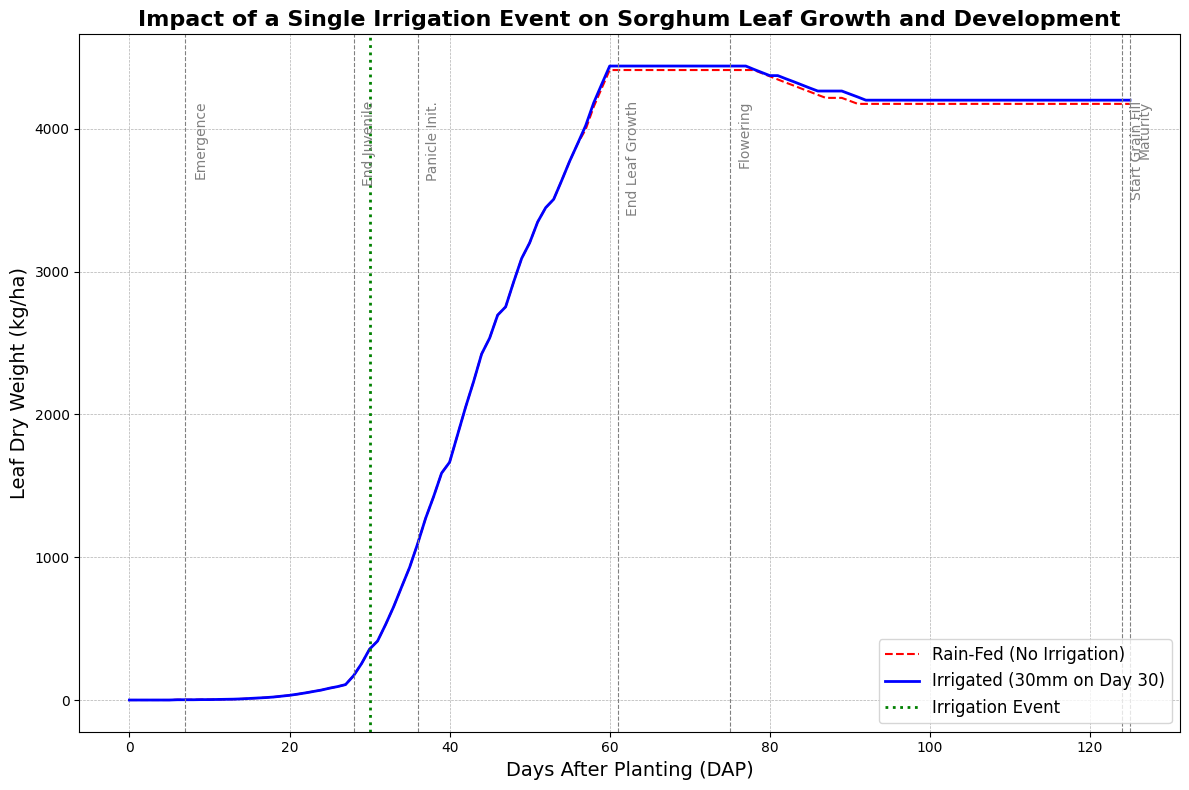

✅ Plot generated successfully.


In [35]:
# Irrigation Comparison and Visualization
from DSSATTools import (
    crop,
    WeatherStation,
    SoilProfile,
    filex,
    DSSAT
)
import pandas as pd
from datetime import datetime, timedelta
import os
import shutil
import matplotlib.pyplot as plt

# --- DEFINE FILE PATHS AND DATES ---
# Using a known-good weather file from the DSSAT examples for reliability
WEATHER_FILE_PATH = r"D:\Final-Year-Project\project-trail\defaults\Weather\ALCL5601.WTH" 
SOIL_FILE_PATH = "MY_GENERATED_SOIL.SOL"
SOIL_ID = "SG12387893"
PLANTING_DATE = datetime(1956, 6, 15) # Adjusted to match the weather file's year

# --- 1. SETUP ---
weather_station = WeatherStation.from_files([WEATHER_FILE_PATH])
soil_profile = SoilProfile.from_file(SOIL_ID, SOIL_FILE_PATH)
cultivar = crop.Sorghum('IB0026')

field = filex.Field(id_field='REALTIME', wsta=weather_station, id_soil=soil_profile)
planting = filex.Planting(pdate=PLANTING_DATE, ppop=18, ppoe=18, plrs=45, pldp=5)

soil_depths = [int(layer['slb']) for layer in soil_profile.table]
initial_values_table = [(depth, 0.35, 1.5, 1.5) for depth in soil_depths]
initial_conditions = filex.InitialConditions(
    pcr='SG', icdat=PLANTING_DATE, icres=1300, icren=0.5,
    table=pd.DataFrame(initial_values_table, columns=['icbl', 'sh2o', 'snh4', 'sno3'])
)

# --- 2. RUN SIMULATION SCENARIOS ---

# Dictionary to store the results of each run
simulation_outputs = {}

for scenario in ["Rain-Fed", "Irrigated"]:
    
    print(f"\n--- Starting '{scenario}' Scenario ---")

    simulation_controls = filex.SimulationControls(
        general=filex.SCGeneral(sdate=PLANTING_DATE),
        options=filex.SCOptions(water='Y', nitro='N', symbi='N'),
        methods=filex.SCMethods(infil='S'),
        management=filex.SCManagement(irrig='A' if scenario == "Irrigated" else 'N', ferti='N', resid='N', harvs='M')
    )

    irrigation = None
    if scenario == "Irrigated":
        irrigation_date = PLANTING_DATE + timedelta(days=30)
        irrigation_events = [
            filex.IrrigationEvent(idate=irrigation_date, irop='IR001', irval=30) # 30mm on Day 30
        ]
        irrigation = filex.Irrigation(table=irrigation_events)

    try:
        workspace = os.path.join("dummy", f"dssat_{scenario.lower()}_run")
        os.makedirs(workspace, exist_ok=True)
        
        shutil.copy(WEATHER_FILE_PATH, workspace)
        shutil.copy(SOIL_FILE_PATH, workspace)
        
        dssat = DSSAT(workspace)
        print(f"🚀 Running simulation in: {workspace}")
        
        run_args = {
            'field': field,
            'cultivar': cultivar,
            'planting': planting,
            'initial_conditions': initial_conditions,
            'simulation_controls': simulation_controls
        }
        if irrigation:
            run_args['irrigation'] = irrigation

        results = dssat.run_treatment(**run_args)
        
        print("\nSummary Output (Evaluate.OUT):")
        print(results)
        
        if 'PlantGro' in dssat.output_tables:
            simulation_outputs[scenario] = dssat.output_tables['PlantGro']

    except Exception as e:
        print(f"❌ An error occurred during the {scenario} run: {e}")


# --- 3. VISUALIZE THE RESULTS ---

if "Rain-Fed" in simulation_outputs and "Irrigated" in simulation_outputs:
    print("\n--- Generating Growth Comparison Plot ---")
    
    # Set the 'DAP' column as the index for both DataFrames for easy plotting
    rainfed_df = simulation_outputs["Rain-Fed"].set_index('DAP')
    irrigated_df = simulation_outputs["Irrigated"].set_index('DAP')
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot Leaf Weight (LWAD) for both scenarios
    rainfed_df['LWAD'].plot(label='Rain-Fed (No Irrigation)', color='red', linestyle='--')
    irrigated_df['LWAD'].plot(label='Irrigated (30mm on Day 30)', color='blue', linewidth=2)
    
    # Add a vertical line to show when the irrigation happened
    plt.axvline(x=30, color='green', linestyle=':', linewidth=2, label='Irrigation Event')
    
    # --- NEW SECTION: ANNOTATE GROWTH STAGES ---
    # Define a mapping from DSSAT growth stage codes to readable names
    stage_map = {
        1: 'Emergence',
        2: 'End Juvenile',
        3: 'Panicle Init.',
        4: 'End Leaf Growth',
        5: 'Flowering',
        6: 'Start Grain Fill',
        7: 'Maturity'
    }

    # Find the days where the growth stage changes
    stage_changes = irrigated_df[irrigated_df['GSTD'].diff() != 0]

    # Add a vertical line and text for each stage change
    for dap, row in stage_changes.iterrows():
        stage_code = int(row['GSTD'])
        if stage_code in stage_map:
            stage_name = stage_map[stage_code]
            plt.axvline(x=dap, color='gray', linestyle='--', linewidth=0.8)
            plt.text(dap + 1, plt.ylim()[1] * 0.9, stage_name, rotation=90, verticalalignment='top', color='gray')
    # --- END OF NEW SECTION ---

    # Add labels and title for clarity
    plt.xlabel("Days After Planting (DAP)", fontsize=14)
    plt.ylabel("Leaf Dry Weight (kg/ha)", fontsize=14)
    plt.title("Impact of a Single Irrigation Event on Sorghum Leaf Growth and Development", fontsize=16, weight='bold')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    print("✅ Plot generated successfully.")

else:
    print("\nCould not generate plot because one or both simulation scenarios failed.")

In [29]:
# Daily RL State Vector Display
from DSSATTools import (
    crop,
    WeatherStation,
    SoilProfile,
    filex,
    DSSAT
)
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import shutil
import matplotlib.pyplot as plt

# --- 1. SIMULATION SETUP (from your working script) ---

# --- DEFINE FILE PATHS AND DATES ---
WEATHER_FILE_PATH = r"D:\Final-Year-Project\project-trail\defaults\Weather\ALCL5601.WTH" 
SOIL_FILE_PATH = "MY_GENERATED_SOIL.SOL"
SOIL_ID = "SG12387893"
PLANTING_DATE = datetime(1956, 6, 15)

# --- Load DSSAT Objects ---
weather_station = WeatherStation.from_files([WEATHER_FILE_PATH])
soil_profile = SoilProfile.from_file(SOIL_ID, SOIL_FILE_PATH)
cultivar = crop.Sorghum('IB0026')

# --- Configure Management ---
field = filex.Field(id_field='REALTIME', wsta=weather_station, id_soil=soil_profile)
planting = filex.Planting(pdate=PLANTING_DATE, ppop=18, ppoe=18, plrs=45, pldp=5)

soil_depths = [int(layer['slb']) for layer in soil_profile.table]
initial_values_table = [(depth, 0.35, 1.5, 1.5) for depth in soil_depths]
initial_conditions = filex.InitialConditions(
    pcr='SG', icdat=PLANTING_DATE, icres=1300, icren=0.5,
    table=pd.DataFrame(initial_values_table, columns=['icbl', 'sh2o', 'snh4', 'sno3'])
)

irrigation_events = [filex.IrrigationEvent(idate=PLANTING_DATE + timedelta(days=day), irop='IR001', irval=5) for day in range(90)]
irrigation = filex.Irrigation(table=irrigation_events)

simulation_controls = filex.SimulationControls(
    general=filex.SCGeneral(sdate=PLANTING_DATE),
    options=filex.SCOptions(water='Y', nitro='N', symbi='N'),
    methods=filex.SCMethods(infil='S'),
    management=filex.SCManagement(irrig='A', ferti='N', resid='N', harvs='M')
)
print("✅ Management files configured.")

# --- 2. RUN SIMULATION ---
dssat_output = None
try:
    workspace = os.path.join("dummy", "dssat_state_run")
    os.makedirs(workspace, exist_ok=True)
    
    shutil.copy(WEATHER_FILE_PATH, workspace)
    shutil.copy(SOIL_FILE_PATH, workspace)
    
    dssat = DSSAT(workspace)
    print(f"🚀 Running simulation in: {workspace}")
    
    results = dssat.run_treatment(
        field=field, cultivar=cultivar, planting=planting,
        initial_conditions=initial_conditions, irrigation=irrigation,
        simulation_controls=simulation_controls
    )
    print("\n--- SIMULATION COMPLETE ---")
    dssat_output = dssat.output_tables

except Exception as e:
    print(f"❌ An error occurred during the DSSAT run: {e}")


✅ Management files configured.
dummy\dssat_state_run created.
🚀 Running simulation in: dummy\dssat_state_run

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1  70 125 17659  8208   279   157   439   182     0   -99      0  186

--- SIMULATION COMPLETE ---


In [33]:
dssat_output.keys()

dict_keys(['PlantGro', 'SoilOrg', 'Weather'])

In [ ]:
PlantGro = dssat_output["PlantGro"]
SoilOrg = dssat_output['SoilOrg']
WeatherOut = dssat_output['Weather']


In [ ]:
pd.set_option('display.max_rows', None) # Display all rows
pd.set_option('display.max_columns', None) # Display all columns
print("dssat_output.keys()", dssat_output.keys())
print("dssat", type(dssat_output["PlantGro"]))
print("dssat", dssat_output["PlantGro"].describe())

print("dssat", type(dssat_output["SoilOrg"]))
print("dssat", dssat_output["SoilOrg"].describe())

print("dssat", type(dssat_output["SoilWat"]))
print("dssat", dssat_output["SoilWat"].describe())

print("dssat", type(dssat_output["Weather"]))
print("dssat", dssat_output["Weather"].describe())

dssat_output.keys() dict_keys(['PlantGro', 'SoilOrg', 'SoilWat', 'Weather'])
dssat <class 'pandas.core.frame.DataFrame'>
dssat               DAS         DAP        L#SD        GSTD        LAID  \
count  126.000000  126.000000  126.000000  126.000000  126.000000   
mean    63.500000   62.500000   16.785714    3.380952    3.912937   
std     36.517119   36.517119    7.632454    1.724446    2.385385   
min      1.000000    0.000000    0.000000    0.000000    0.000000   
25%     32.250000   31.250000   11.300000    2.000000    1.535000   
50%     63.500000   62.500000   22.500000    4.000000    4.490000   
75%     94.750000   93.750000   22.500000    5.000000    5.532500   
max    126.000000  125.000000   22.500000    7.000000    7.400000   

              LWAD         SWAD         GWAD         RWAD         VWAD  \
count   126.000000   126.000000   126.000000   126.000000   126.000000   
mean   2815.333333  1555.896825  2358.857143   696.063492  4371.317460   
std    1848.427444  1379.8655

dssat_output.keys() dict_keys(['PlantGro', 'SoilOrg', 'SoilWat', 'Weather'])
dssat <class 'pandas.core.frame.DataFrame'>
dssat               DAS         DAP        L#SD        GSTD        LAID  \
count  126.000000  126.000000  126.000000  126.000000  126.000000   
mean    63.500000   62.500000   16.785714    3.380952    3.912937   
std     36.517119   36.517119    7.632454    1.724446    2.385385   
min      1.000000    0.000000    0.000000    0.000000    0.000000   
25%     32.250000   31.250000   11.300000    2.000000    1.535000   
50%     63.500000   62.500000   22.500000    4.000000    4.490000   
75%     94.750000   93.750000   22.500000    5.000000    5.532500   
max    126.000000  125.000000   22.500000    7.000000    7.400000   

              LWAD         SWAD         GWAD         RWAD         VWAD  \
count   126.000000   126.000000   126.000000   126.000000   126.000000   
mean   2815.333333  1555.896825  2358.857143   696.063492  4371.317460   
std    1848.427444  1379.865569  3146.333149   437.662441  3125.268848   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%     441.750000    34.750000     0.000000   226.000000   475.750000   
50%    4200.000000  1863.000000     0.000000   981.500000  6301.000000   
75%    4237.750000  2639.750000  5467.500000  1034.750000  6929.250000   
max    4439.000000  4569.000000  8208.000000  1281.000000  9007.000000   

               CWAD          G#AD        GWGD        HIAD          PWAD  \
count    126.000000    126.000000  126.000000  126.000000    126.000000   
mean    7319.920635  11481.071429    8.314286    0.159651   2948.595238   
std     6389.037680  13978.424612   11.091645    0.201482   3932.975228   
min        0.000000      0.000000    0.000000    0.000000      0.000000   
25%      475.750000      0.000000    0.000000    0.000000      0.000000   
50%     6301.000000      0.000000    0.000000    0.000000      0.000000   
75%    13619.500000  28365.000000   19.250000    0.401500   6834.250000   
max    17659.000000  28365.000000   28.900000    0.465000  10261.000000   

             P#AD   WSPD   WSGD   NSTD        EWSD  PST1A  PST2A   KSTD  \
count  126.000000  126.0  126.0  126.0  126.000000  126.0  126.0  126.0   
mean     7.285714    0.0    0.0    0.0    0.109683    0.0    0.0    0.0   
std      8.870497    0.0    0.0    0.0    0.135863    0.0    0.0    0.0   
min      0.000000    0.0    0.0    0.0    0.000000    0.0    0.0    0.0   
25%      0.000000    0.0    0.0    0.0    0.000000    0.0    0.0    0.0   
50%      0.000000    0.0    0.0    0.0    0.055000    0.0    0.0    0.0   
75%     18.000000    0.0    0.0    0.0    0.174500    0.0    0.0    0.0   
max     18.000000    0.0    0.0    0.0    0.573000    0.0    0.0    0.0   

        LN%D   SH%D        HIPD   PWDD          PWTD        SLAD   CHTD  \
count  126.0  126.0  126.000000  126.0    126.000000  126.000000  126.0   
mean     0.0    0.0    0.199603    0.0   2948.595238  192.361111    0.0   
std      0.0    0.0    0.251884    0.0   3932.975228  128.398172    0.0   
min      0.0    0.0    0.000000    0.0      0.000000    0.000000    0.0   
25%      0.0    0.0    0.000000    0.0      0.000000  107.800000    0.0   
50%      0.0    0.0    0.000000    0.0      0.000000  131.350000    0.0   
75%      0.0    0.0    0.500000    0.0   6834.250000  250.375000    0.0   
max      0.0    0.0    0.580000    0.0  10261.000000  492.500000    0.0   

        CWID        RDPD        RL1D        RL2D        RL3D        RL4D  \
count  126.0  126.000000  126.000000  126.000000  126.000000  126.000000   
mean     0.0    1.341667    2.040794    2.020873    1.958571    1.490873   
std      0.0    0.601237    1.036997    1.102039    1.108631    0.895033   
min      0.0    0.070000    0.000000    0.000000    0.000000    0.000000   
25%      0.0    0.877500    0.932500    0.942500    0.865000    0.602500   
50%      0.0    1.475000    2.710000    2.735000    2.675000    2.075000   
75%      0.0    1.925000    2.855000    2.877500    2.817500    2.180000   
max      0.0    2.000000    3.410000    3.430000    3.380000    2.650000   

             RL5D        RL6D        RL7D        RL8D        RL9D       RL10D  \
count  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000   
mean     1.460794    0.783492    0.314762    0.086746    0.025397    0.019206   
std      0.887343    0.519634    0.244938    0.087907    0.049163    0.044732   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.570000    0.157500    0.000000    0.000000    0.000000    0.000000   
50%      2.035000    1.130000    0.475000    0.100000    0.000000    0.000000   
75%      2.150000    1.190000    0.510000    0.140000    0.020000    0.007500   
max      2.610000    1.510000    0.740000    0.330000    0.230000    0.220000   

        CDAD   LDAD   SDAD  SNW0C  SNW1C        DTTD  
count  126.0  126.0  126.0  126.0  126.0  126.000000  
mean     0.0    0.0    0.0    0.0    0.0   16.224524  
std      0.0    0.0    0.0    0.0    0.0    4.144324  
min      0.0    0.0    0.0    0.0    0.0    0.000000  
25%      0.0    0.0    0.0    0.0    0.0   14.000000  
50%      0.0    0.0    0.0    0.0    0.0   17.720000  
75%      0.0    0.0    0.0    0.0    0.0   19.395000  
max      0.0    0.0    0.0    0.0    0.0   21.170000  
dssat <class 'pandas.core.frame.DataFrame'>
dssat               DAS   OMAC          SCDD           SOCD        SC0D  \
count  127.000000  127.0    127.000000     127.000000  127.000000   
mean    63.000000    0.0  20431.503937  186771.834646  264.708661   
std     36.805797    0.0    143.646992     589.837626  106.865597   
min      0.000000    0.0  20212.000000  185903.000000  146.000000   
25%     31.500000    0.0  20304.000000  186254.500000  173.500000   
50%     63.000000    0.0  20421.000000  186698.000000  226.000000   
75%     94.500000    0.0  20562.500000  187292.000000  347.000000   
max    126.000000    0.0  20678.000000  187871.000000  520.000000   

                SCTD          SOMCT   LCTD   ONAC   SNDD   SOND   SN0D   SNTD  \
count     127.000000     127.000000  127.0  127.0  127.0  127.0  127.0  127.0   
mean   186507.149606  186507.149606    0.0    0.0    0.0    0.0    0.0    0.0   
std       485.671554     485.671554    0.0    0.0    0.0    0.0    0.0    0.0   
min    185757.000000  185757.000000    0.0    0.0    0.0    0.0    0.0    0.0   
25%    186080.500000  186080.500000    0.0    0.0    0.0    0.0    0.0    0.0   
50%    186472.000000  186472.000000    0.0    0.0    0.0    0.0    0.0    0.0   
75%    186945.500000  186945.500000    0.0    0.0    0.0    0.0    0.0    0.0   
max    187351.000000  187351.000000    0.0    0.0    0.0    0.0    0.0    0.0   

       SOMNT   LNTD  
count  127.0  127.0  
mean     0.0    0.0  
std      0.0    0.0  
min      0.0    0.0  
25%      0.0    0.0  
50%      0.0    0.0  
75%      0.0    0.0  
max      0.0    0.0  
dssat <class 'pandas.core.frame.DataFrame'>
dssat               DAS        SWTD        SWXD        ROFC   DRNC        PREC  \
count  127.000000  127.000000  127.000000  127.000000  127.0  127.000000   
mean    63.000000  681.307087  194.716535    4.566929    0.0  125.858268   
std     36.805797   26.587535   26.579888    9.374561    0.0   72.328146   
min      0.000000  628.000000  142.000000    0.000000    0.0    0.000000   
25%     31.500000  659.000000  172.500000    0.000000    0.0   77.500000   
50%     63.000000  680.000000  194.000000    1.000000    0.0  119.000000   
75%     94.500000  707.500000  220.500000    1.000000    0.0  140.000000   
max    126.000000  723.000000  237.000000   28.000000    0.0  279.000000   

             IR#C        IRRC        DTWT        MWTD   TDFD   TDFC  \
count  127.000000  127.000000  127.000000  127.000000  127.0  127.0   
mean     2.149606   67.307087  197.251969    0.160630    0.0    0.0   
std      1.992361   62.494763   22.046476    0.089156    0.0    0.0   
min      0.000000    0.000000    0.000000    0.040000    0.0    0.0   
25%      0.000000    0.000000  200.000000    0.095000    0.0    0.0   
50%      1.000000   31.000000  200.000000    0.150000    0.0    0.0   
75%      4.000000  124.000000  200.000000    0.200000    0.0    0.0   
max      5.000000  157.000000  200.000000    0.440000    0.0    0.0   

             ROFD        SW1D        SW2D        SW3D        SW4D        SW5D  \
count  127.000000  127.000000  127.000000  127.000000  127.000000  127.000000   
mean     0.221969    0.355772    0.374646    0.365197    0.350173    0.325992   
std      1.712026    0.047541    0.025956    0.032212    0.042003    0.042498   
min      0.000000    0.236000    0.311000    0.293000    0.287000    0.276000   
25%      0.000000    0.334500    0.353000    0.346500    0.305000    0.282000   
50%      0.000000    0.368000    0.380000    0.374000    0.361000    0.323000   
75%      0.000000    0.393000    0.396000    0.391000    0.388000    0.366000   
max     17.560000    0.412000    0.412000    0.406000    0.410000    0.410000   

             SW6D        SW7D        SW8D        SW9D        SW10  
count  127.000000  127.000000  127.000000  127.000000  127.000000  
mean     0.319370    0.325677    0.340213    0.348039    0.349307  
std      0.027899    0.021177    0.010821    0.003100    0.001581  
min      0.283000    0.300000    0.321000    0.338000    0.343000  
25%      0.290500    0.304000    0.329500    0.347000    0.350000  
50%      0.321000    0.321000    0.346000    0.350000    0.350000  
75%      0.350000    0.350000    0.350000    0.350000    0.350000  
max      0.361000    0.350000    0.350000    0.350000    0.350000  
dssat <class 'pandas.core.frame.DataFrame'>
dssat               DAS        PRED       DAYLD        TWLD        SRAD        PARD  \
count  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000   
mean    63.500000    2.211111   12.950794   13.988095   16.702381   33.404762   
std     36.517119    7.185054    0.989929    1.032326    4.244120    8.488240   
min      1.000000    0.000000   11.100000   12.100000    5.900000   11.800000   
25%     32.250000    0.000000   12.100000   13.100000   14.200000   28.400000   
50%     63.500000    0.000000   13.100000   14.150000   17.200000   34.400000   
75%     94.750000    0.000000   13.900000   15.000000   19.475000   38.950000   
max    126.000000   57.200000   14.100000   15.200000   25.800000   51.600000   

             CLDD        TMXD        TMND        TAVD        TDYD        TDWD  \
count  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000   
mean     0.399683   31.619048   16.666667   24.015873   26.638889   16.666667   
std      0.176811    3.977652    4.633789    4.095117    3.920265    4.633789   
min      0.000000   20.000000    3.000000   13.300000   16.500000    3.000000   
25%      0.310000   29.000000   14.000000   21.650000   23.825000   14.000000   
50%      0.405000   33.000000   19.000000   25.600000   27.900000   19.000000   
75%      0.500000   34.000000   20.000000   27.075000   29.475000   20.000000   
max      0.800000   38.000000   23.000000   29.600000   32.400000   23.000000   

             TGAD        TGRD          WDSD          CO2D   VPDF    VPD  \
count  126.000000  126.000000  1.260000e+02  1.260000e+02  126.0  126.0   
mean    24.015873   26.638889  8.640000e+01  3.149000e+02    0.0    0.0   
std      4.095117    3.920265  1.426758e-14  1.141407e-13    0.0    0.0   
min     13.300000   16.500000  8.640000e+01  3.149000e+02    0.0    0.0   
25%     21.650000   23.825000  8.640000e+01  3.149000e+02    0.0    0.0   
50%     25.600000   27.900000  8.640000e+01  3.149000e+02    0.0    0.0   
75%     27.075000   29.475000  8.640000e+01  3.149000e+02    0.0    0.0   
max     29.600000   32.400000  8.640000e+01  3.149000e+02    0.0    0.0   

       OZON7         WDATE  
count  126.0  1.260000e+02  
mean   -99.0  1.956230e+06  
std      0.0  3.651712e+01  
min    -99.0  1.956167e+06  
25%    -99.0  1.956198e+06  
50%    -99.0  1.956230e+06  
75%    -99.0  1.956261e+06  
max    -99.0  1.956292e+06

✅ Management files configured.
dummy\dssat_state_run created.
🚀 Running simulation in: dummy\dssat_state_run

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1  70 125 17659  8208   279   157   439   182     0   -99      0  186

--- SIMULATION COMPLETE ---

--- Constructing Daily RL State Vector ---

--- Daily State Vector (First 15 Days) ---
    days_after_planting  phenological_stage  leaf_area_index  total_biomass  \
0                     0                   0             0.00              0   
1                     1                   0             0.00              0   
2                     2                   0             0.00              0   
3                     3                   0             0.00              0   
4                     4                   0             0.00              0   
5                     5                   0             0.00  

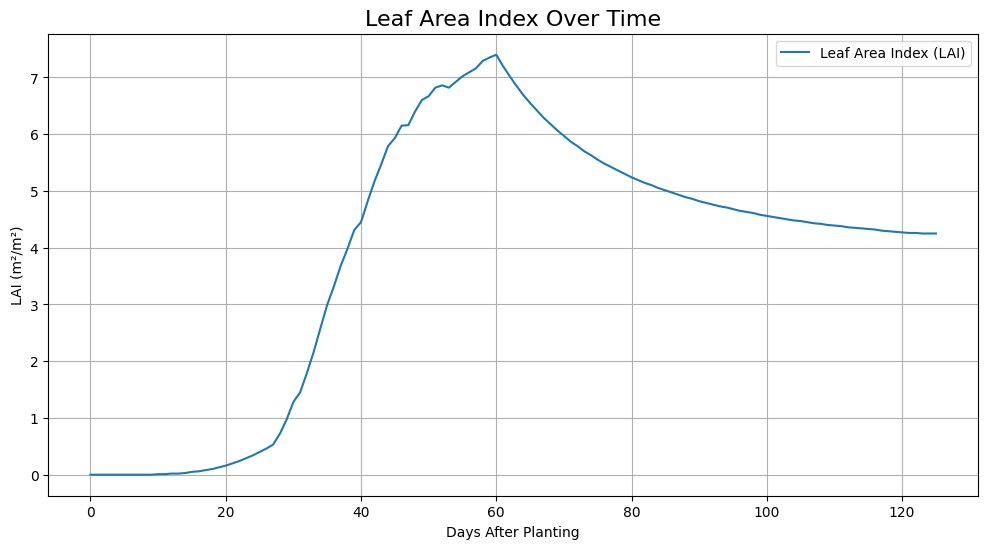

In [26]:
# Daily RL State Vector Display
from DSSATTools import (
    crop,
    WeatherStation,
    SoilProfile,
    filex,
    DSSAT
)
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import shutil
import matplotlib.pyplot as plt

# --- 1. SIMULATION SETUP (from your working script) ---

# --- DEFINE FILE PATHS AND DATES ---
WEATHER_FILE_PATH = r"D:\Final-Year-Project\project-trail\defaults\Weather\ALCL5601.WTH" 
SOIL_FILE_PATH = "MY_GENERATED_SOIL.SOL"
SOIL_ID = "SG12387893"
PLANTING_DATE = datetime(1956, 6, 15)

# --- Load DSSAT Objects ---
weather_station = WeatherStation.from_files([WEATHER_FILE_PATH])
soil_profile = SoilProfile.from_file(SOIL_ID, SOIL_FILE_PATH)
cultivar = crop.Sorghum('IB0026')

# --- Configure Management ---
field = filex.Field(id_field='REALTIME', wsta=weather_station, id_soil=soil_profile)
planting = filex.Planting(pdate=PLANTING_DATE, ppop=18, ppoe=18, plrs=45, pldp=5)

soil_depths = [int(layer['slb']) for layer in soil_profile.table]
initial_values_table = [(depth, 0.35, 1.5, 1.5) for depth in soil_depths]
initial_conditions = filex.InitialConditions(
    pcr='SG', icdat=PLANTING_DATE, icres=1300, icren=0.5,
    table=pd.DataFrame(initial_values_table, columns=['icbl', 'sh2o', 'snh4', 'sno3'])
)

irrigation_events = [filex.IrrigationEvent(idate=PLANTING_DATE + timedelta(days=day), irop='IR001', irval=5) for day in range(90)]
irrigation = filex.Irrigation(table=irrigation_events)

simulation_controls = filex.SimulationControls(
    general=filex.SCGeneral(sdate=PLANTING_DATE),
    options=filex.SCOptions(water='Y', nitro='N', symbi='N'),
    methods=filex.SCMethods(infil='S'),
    management=filex.SCManagement(irrig='A', ferti='N', resid='N', harvs='M'),
    outputs=filex.SCOutputs(
        grout='Y',  # Growth output (PlantGro.OUT)
        waout='Y',  # Water output (SoilWat.OUT)
        niout='Y'   # Nitrogen output (SoilNi.OUT)
    )
)
print("✅ Management files configured.")

# --- 2. RUN SIMULATION ---
dssat_output = None
try:
    workspace = os.path.join("dummy", "dssat_state_run")
    os.makedirs(workspace, exist_ok=True)
    
    shutil.copy(WEATHER_FILE_PATH, workspace)
    shutil.copy(SOIL_FILE_PATH, workspace)
    
    dssat = DSSAT(workspace)
    print(f"🚀 Running simulation in: {workspace}")
    
    results = dssat.run_treatment(
        field=field, cultivar=cultivar, planting=planting,
        initial_conditions=initial_conditions, irrigation=irrigation,
        simulation_controls=simulation_controls
    )
    print("\n--- SIMULATION COMPLETE ---")
    dssat_output = dssat.output_tables

except Exception as e:
    print(f"❌ An error occurred during the DSSAT run: {e}")


# --- 3. CONSTRUCT THE DAILY STATE VECTOR DATAFRAME ---

if dssat_output and 'SoilWat' in dssat_output:
    print("\n--- Constructing Daily RL State Vector ---")
    
    # Base DataFrames
    plantgro = dssat_output['PlantGro'].set_index('DAP')
    
    soilwat_full = dssat_output['SoilWat']
    soilwat_full['DAP'] = soilwat_full['DAS'] - 1 
    soilwat_full = soilwat_full.set_index('DAP')

    weather_df_full = pd.DataFrame(weather_station.table).copy()
    weather_df_full['date'] = pd.to_datetime(weather_df_full['date'])
    weather_df_full['DAP'] = (weather_df_full['date'] - PLANTING_DATE).dt.days
    weather_df_full = weather_df_full.set_index('DAP')
    
    # Select only the specific columns needed from each dataframe to avoid overlap.
    soilwat_cols_to_join = [col for col in soilwat_full.columns if col.startswith('SW') or col in ['SWXD', 'ETD']]
    weather_cols_to_join = ['srad', 'tmax', 'tmin', 'rain']
    
    soilwat_selected = soilwat_full[soilwat_cols_to_join]
    weather_selected = weather_df_full[weather_cols_to_join]
    
    # Combine all data sources
    combined_df = plantgro.join(soilwat_selected, how='inner').join(weather_selected, how='left')
    
    # Get soil layer depths for calculations
    soil_layers = soil_profile.table
    layer_depths = np.array([float(layer['slb']) for layer in soil_layers])

    state_records = []

    for dap in range(len(combined_df)):
        current_day_data = combined_df.iloc[dap]
        history = combined_df.iloc[max(0, dap-7):dap+1]
        
        # Helper to get soil water for a depth range
        def get_sw_by_depth(min_depth, max_depth):
            # --- THE FIX IS HERE ---
            # Added a 'D' to the end of the column name to match the SoilWat.OUT format (e.g., SW1D)
            sw_cols = [f'SW{i+1}D' for i, depth in enumerate(layer_depths) if min_depth < depth <= max_depth]
            # --- END OF FIX ---
            return current_day_data[sw_cols].mean() if sw_cols else np.nan

        state = {
            # Crop Variables
            'days_after_planting': dap,
            'phenological_stage': current_day_data.get('GSTD', 0),
            'leaf_area_index': current_day_data.get('LAID', 0),
            'total_biomass': current_day_data.get('CWAD', 0),
            'cumulative_gdd': 0, # Placeholder

            # Soil Variables
            'soil_water_content_0_30cm': get_sw_by_depth(0, 30),
            'soil_water_content_30_60cm': get_sw_by_depth(30, 60),
            'soil_water_content_60_100cm': get_sw_by_depth(60, 100),
            'available_water_fraction': current_day_data.get('SWXD', 0),
            'water_stress_factor': current_day_data.get('WSGD', 0),
            'days_since_last_rain': (history['rain'] == 0)[::-1].cumprod().sum() if dap > 0 else 0,
            
            # Weather Variables
            'rainfall_1day': history['rain'].iloc[-1:].sum(),
            'rainfall_3day': history['rain'].iloc[-3:].sum(),
            'rainfall_7day': history['rain'].iloc[-7:].sum(),
            'temperature_min': current_day_data.get('tmin', 0),
            'temperature_max': current_day_data.get('tmax', 0),
            'temperature_avg': (current_day_data.get('tmax', 0) + current_day_data.get('tmin', 0)) / 2,
            'solar_radiation': current_day_data.get('srad', 0),
            'reference_et': current_day_data.get('ETD', 0),
            'forecast_rain_mm': 0,
            
            # Irrigation History
            'last_irrigation_amount': 5 if dap < 90 else 0,
            'days_since_last_irrigation': 0 if dap < 90 else dap - 89,
            'cumulative_irrigation': min(dap + 1, 90) * 5,
        }
        state_records.append(state)

    state_df = pd.DataFrame(state_records)
    state_df = state_df.fillna(0)
    
    print("\n--- Daily State Vector (First 15 Days) ---")
    display_cols = [
        'days_after_planting', 'phenological_stage', 'leaf_area_index', 'total_biomass',
        'soil_water_content_0_30cm', 'water_stress_factor', 'rainfall_7day',
        'last_irrigation_amount', 'cumulative_irrigation'
    ]
    print(state_df[display_cols].head(15).round(2))

    plt.figure(figsize=(12, 6))
    plt.plot(state_df['days_after_planting'], state_df['leaf_area_index'], label='Leaf Area Index (LAI)')
    plt.title('Leaf Area Index Over Time', fontsize=16)
    plt.xlabel('Days After Planting')
    plt.ylabel('LAI (m²/m²)')
    plt.grid(True)
    plt.legend()
    plt.show()

else:
    print("\nSimulation output is missing or incomplete. Could not construct state vector.")



✅ Management files configured.
dummy\dssat_state_run created.
🚀 Running simulation in: dummy\dssat_state_run

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1  70 125 17659  8208   279   157   439   182     0   -99      0  186

--- SIMULATION COMPLETE ---

--- Constructing Daily RL State Vector ---

--- Daily State Vector (First 15 Days) ---
    days_after_planting  phenological_stage  leaf_area_index  total_biomass  \
0                     0                   0             0.00              0   
1                     1                   0             0.00              0   
2                     2                   0             0.00              0   
3                     3                   0             0.00              0   
4                     4                   0             0.00              0   
5                     5                   0             0.00  

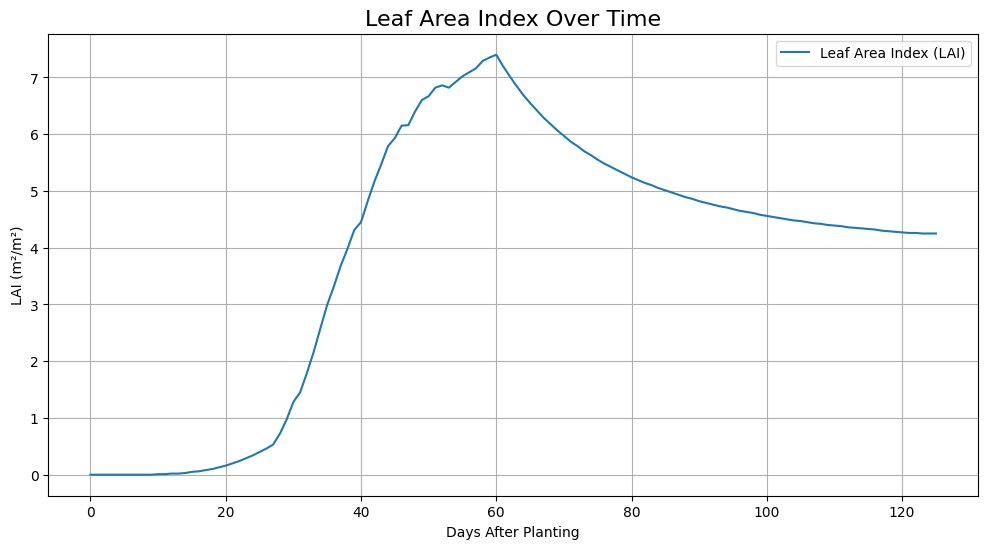

In [27]:
# Daily RL State Vector Display
from DSSATTools import (
    crop,
    WeatherStation,
    SoilProfile,
    filex,
    DSSAT
)
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import shutil
import matplotlib.pyplot as plt

# --- 1. SIMULATION SETUP (from your working script) ---

# --- DEFINE FILE PATHS AND DATES ---
WEATHER_FILE_PATH = r"D:\Final-Year-Project\project-trail\defaults\Weather\ALCL5601.WTH" 
SOIL_FILE_PATH = "MY_GENERATED_SOIL.SOL"
SOIL_ID = "SG12387893"
PLANTING_DATE = datetime(1956, 6, 15)

# --- Load DSSAT Objects ---
weather_station = WeatherStation.from_files([WEATHER_FILE_PATH])
soil_profile = SoilProfile.from_file(SOIL_ID, SOIL_FILE_PATH)
cultivar = crop.Sorghum('IB0026')

# --- Configure Management ---
field = filex.Field(id_field='REALTIME', wsta=weather_station, id_soil=soil_profile)
planting = filex.Planting(pdate=PLANTING_DATE, ppop=18, ppoe=18, plrs=45, pldp=5)

soil_depths = [int(layer['slb']) for layer in soil_profile.table]
initial_values_table = [(depth, 0.35, 1.5, 1.5) for depth in soil_depths]
initial_conditions = filex.InitialConditions(
    pcr='SG', icdat=PLANTING_DATE, icres=1300, icren=0.5,
    table=pd.DataFrame(initial_values_table, columns=['icbl', 'sh2o', 'snh4', 'sno3'])
)

irrigation_events = [filex.IrrigationEvent(idate=PLANTING_DATE + timedelta(days=day), irop='IR001', irval=5) for day in range(90)]
irrigation = filex.Irrigation(table=irrigation_events)

simulation_controls = filex.SimulationControls(
    general=filex.SCGeneral(sdate=PLANTING_DATE),
    options=filex.SCOptions(water='Y', nitro='N', symbi='N'),
    methods=filex.SCMethods(infil='S'),
    management=filex.SCManagement(irrig='A', ferti='N', resid='N', harvs='M'),
    outputs=filex.SCOutputs(
        grout='Y',  # Growth output (PlantGro.OUT)
        waout='Y',  # Water output (SoilWat.OUT)
        niout='Y'   # Nitrogen output (SoilNi.OUT)
    )
)
print("✅ Management files configured.")

# --- 2. RUN SIMULATION ---
dssat_output = None
try:
    workspace = os.path.join("dummy", "dssat_state_run")
    os.makedirs(workspace, exist_ok=True)
    
    shutil.copy(WEATHER_FILE_PATH, workspace)
    shutil.copy(SOIL_FILE_PATH, workspace)
    
    dssat = DSSAT(workspace)
    print(f"🚀 Running simulation in: {workspace}")
    
    results = dssat.run_treatment(
        field=field, cultivar=cultivar, planting=planting,
        initial_conditions=initial_conditions, irrigation=irrigation,
        simulation_controls=simulation_controls
    )
    print("\n--- SIMULATION COMPLETE ---")
    dssat_output = dssat.output_tables

except Exception as e:
    print(f"❌ An error occurred during the DSSAT run: {e}")


# --- 3. CONSTRUCT THE DAILY STATE VECTOR DATAFRAME ---

if dssat_output and 'SoilWat' in dssat_output:
    print("\n--- Constructing Daily RL State Vector ---")
    
    # Base DataFrames
    plantgro = dssat_output['PlantGro'].set_index('DAP')
    
    soilwat_full = dssat_output['SoilWat']
    soilwat_full['DAP'] = soilwat_full['DAS'] - 1 
    soilwat_full = soilwat_full.set_index('DAP')

    weather_df_full = pd.DataFrame(weather_station.table).copy()
    weather_df_full['date'] = pd.to_datetime(weather_df_full['date'])
    weather_df_full['DAP'] = (weather_df_full['date'] - PLANTING_DATE).dt.days
    weather_df_full = weather_df_full.set_index('DAP')
    
    # --- THE FIX IS HERE ---
    # Select only the specific columns needed from each dataframe to avoid overlap.
    soilwat_cols_to_join = [col for col in soilwat_full.columns if col.startswith('SW') or col in ['SWXD', 'ETD']]
    weather_cols_to_join = ['srad', 'tmax', 'tmin', 'rain']
    
    soilwat_selected = soilwat_full[soilwat_cols_to_join]
    weather_selected = weather_df_full[weather_cols_to_join]
    
    # Combine all data sources using the selected columns
    combined_df = plantgro.join(soilwat_selected, how='inner').join(weather_selected, how='left')
    # --- END OF FIX ---
    
    # Get soil layer depths for calculations
    soil_layers = soil_profile.table
    layer_depths = np.array([float(layer['slb']) for layer in soil_layers])

    state_records = []

    for dap in range(len(combined_df)):
        current_day_data = combined_df.iloc[dap]
        history = combined_df.iloc[max(0, dap-7):dap+1]
        
        # Helper to get soil water for a depth range
        def get_sw_by_depth(min_depth, max_depth):
            sw_cols = [f'SW{i+1}D' for i, depth in enumerate(layer_depths) if min_depth < depth <= max_depth]
            return current_day_data[sw_cols].mean() if sw_cols else np.nan

        state = {
            # Crop Variables
            'days_after_planting': dap,
            'phenological_stage': current_day_data.get('GSTD', 0),
            'leaf_area_index': current_day_data.get('LAID', 0),
            'total_biomass': current_day_data.get('CWAD', 0),
            'cumulative_gdd': 0, # Placeholder

            # Soil Variables
            'soil_water_content_0_30cm': get_sw_by_depth(0, 30),
            'soil_water_content_30_60cm': get_sw_by_depth(30, 60),
            'soil_water_content_60_100cm': get_sw_by_depth(60, 100),
            'available_water_fraction': current_day_data.get('SWXD', 0),
            'water_stress_factor': current_day_data.get('WSGD', 0),
            'days_since_last_rain': (history['rain'] == 0)[::-1].cumprod().sum() if dap > 0 else 0,
            
            # Weather Variables
            'rainfall_1day': history['rain'].iloc[-1:].sum(),
            'rainfall_3day': history['rain'].iloc[-3:].sum(),
            'rainfall_7day': history['rain'].iloc[-7:].sum(),
            'temperature_min': current_day_data.get('tmin', 0),
            'temperature_max': current_day_data.get('tmax', 0),
            'temperature_avg': (current_day_data.get('tmax', 0) + current_day_data.get('tmin', 0)) / 2,
            'solar_radiation': current_day_data.get('srad', 0),
            'reference_et': current_day_data.get('ETD', 0),
            'forecast_rain_mm': 0,
            
            # Irrigation History
            'last_irrigation_amount': 5 if dap < 90 else 0,
            'days_since_last_irrigation': 0 if dap < 90 else dap - 89,
            'cumulative_irrigation': min(dap + 1, 90) * 5,
        }
        state_records.append(state)

    state_df = pd.DataFrame(state_records)
    state_df = state_df.fillna(0)
    
    # Display all 26 columns of the final state vector DataFrame
    pd.set_option('display.max_columns', None)
    print("\n--- Daily State Vector (First 15 Days) ---")
    print(state_df.head(15).round(2))

    plt.figure(figsize=(12, 6))
    plt.plot(state_df['days_after_planting'], state_df['leaf_area_index'], label='Leaf Area Index (LAI)')
    plt.title('Leaf Area Index Over Time', fontsize=16)
    plt.xlabel('Days After Planting')
    plt.ylabel('LAI (m²/m²)')
    plt.grid(True)
    plt.legend()
    plt.show()

else:
    print("\nSimulation output is missing or incomplete. Could not construct state vector.")



✅ Management files configured.
dummy\dssat_state_run created.
🚀 Running simulation in: dummy\dssat_state_run

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1  70 125 17659  8208   279   157   439   182     0   -99      0  186

--- SIMULATION COMPLETE ---

--- Constructing Daily RL State Vector ---

--- Daily State Vector (First 15 Days) ---
    days_after_planting  phenological_stage  leaf_area_index  total_biomass  \
0                     0                   0             0.00              0   
1                     1                   0             0.00              0   
2                     2                   0             0.00              0   
3                     3                   0             0.00              0   
4                     4                   0             0.00              0   
5                     5                   0             0.00  

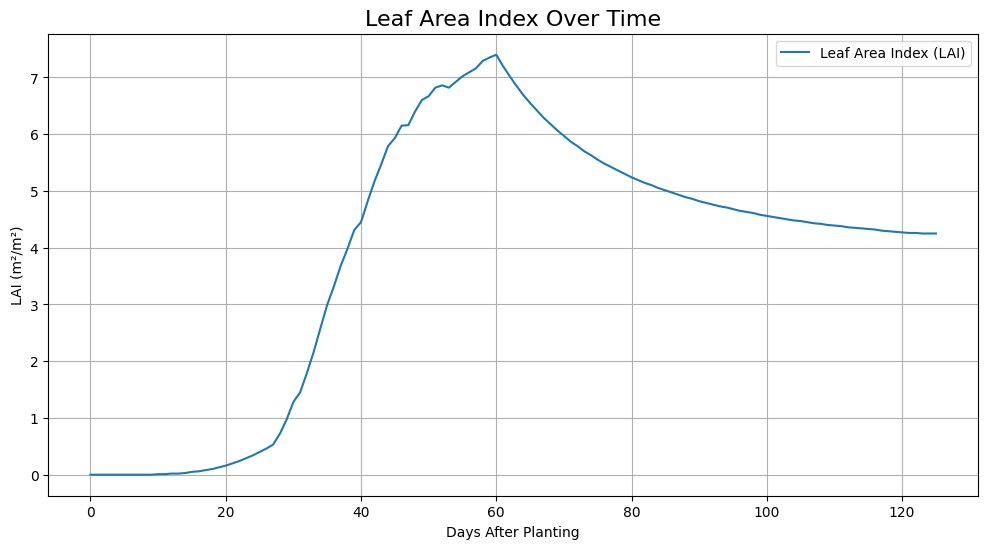

In [28]:
# Daily RL State Vector Display
from DSSATTools import (
    crop,
    WeatherStation,
    SoilProfile,
    filex,
    DSSAT
)
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import shutil
import matplotlib.pyplot as plt

# --- 1. SIMULATION SETUP (from your working script) ---

# --- DEFINE FILE PATHS AND DATES ---
WEATHER_FILE_PATH = r"D:\Final-Year-Project\project-trail\defaults\Weather\ALCL5601.WTH" 
SOIL_FILE_PATH = "MY_GENERATED_SOIL.SOL"
SOIL_ID = "SG12387893"
PLANTING_DATE = datetime(1956, 6, 15)

# --- Load DSSAT Objects ---
weather_station = WeatherStation.from_files([WEATHER_FILE_PATH])
soil_profile = SoilProfile.from_file(SOIL_ID, SOIL_FILE_PATH)
cultivar = crop.Sorghum('IB0026')

# --- Configure Management ---
field = filex.Field(id_field='REALTIME', wsta=weather_station, id_soil=soil_profile)
planting = filex.Planting(pdate=PLANTING_DATE, ppop=18, ppoe=18, plrs=45, pldp=5)

soil_depths = [int(layer['slb']) for layer in soil_profile.table]
initial_values_table = [(depth, 0.35, 1.5, 1.5) for depth in soil_depths]
initial_conditions = filex.InitialConditions(
    pcr='SG', icdat=PLANTING_DATE, icres=1300, icren=0.5,
    table=pd.DataFrame(initial_values_table, columns=['icbl', 'sh2o', 'snh4', 'sno3'])
)

irrigation_events = [filex.IrrigationEvent(idate=PLANTING_DATE + timedelta(days=day), irop='IR001', irval=5) for day in range(90)]
irrigation = filex.Irrigation(table=irrigation_events)

simulation_controls = filex.SimulationControls(
    general=filex.SCGeneral(sdate=PLANTING_DATE),
    options=filex.SCOptions(water='Y', nitro='N', symbi='N'),
    methods=filex.SCMethods(infil='S'),
    management=filex.SCManagement(irrig='A', ferti='N', resid='N', harvs='M'),
    outputs=filex.SCOutputs(
        grout='Y',  # Growth output (PlantGro.OUT)
        waout='Y',  # Water output (SoilWat.OUT)
        niout='Y'   # Nitrogen output (SoilNi.OUT)
    )
)
print("✅ Management files configured.")

# --- 2. RUN SIMULATION ---
dssat_output = None
try:
    workspace = os.path.join("dummy", "dssat_state_run")
    os.makedirs(workspace, exist_ok=True)
    
    shutil.copy(WEATHER_FILE_PATH, workspace)
    shutil.copy(SOIL_FILE_PATH, workspace)
    
    dssat = DSSAT(workspace)
    print(f"🚀 Running simulation in: {workspace}")
    
    results = dssat.run_treatment(
        field=field, cultivar=cultivar, planting=planting,
        initial_conditions=initial_conditions, irrigation=irrigation,
        simulation_controls=simulation_controls
    )
    print("\n--- SIMULATION COMPLETE ---")
    dssat_output = dssat.output_tables

except Exception as e:
    print(f"❌ An error occurred during the DSSAT run: {e}")


# --- 3. CONSTRUCT THE DAILY STATE VECTOR DATAFRAME ---

if dssat_output and 'SoilWat' in dssat_output:
    print("\n--- Constructing Daily RL State Vector ---")
    
    # Base DataFrames
    plantgro = dssat_output['PlantGro'].set_index('DAP')
    
    soilwat_full = dssat_output['SoilWat']
    soilwat_full['DAP'] = soilwat_full['DAS'] - 1 
    soilwat_full = soilwat_full.set_index('DAP')

    weather_df_full = pd.DataFrame(weather_station.table).copy()
    weather_df_full['date'] = pd.to_datetime(weather_df_full['date'])
    weather_df_full['DAP'] = (weather_df_full['date'] - PLANTING_DATE).dt.days
    weather_df_full = weather_df_full.set_index('DAP')
    
    soilwat_cols_to_join = [col for col in soilwat_full.columns if col.startswith('SW') or col in ['SWXD', 'ETD']]
    weather_cols_to_join = ['srad', 'tmax', 'tmin', 'rain']
    
    soilwat_selected = soilwat_full[soilwat_cols_to_join]
    weather_selected = weather_df_full[weather_cols_to_join]
    
    combined_df = plantgro.join(soilwat_selected, how='inner').join(weather_selected, how='left')
    
    soil_layers = soil_profile.table
    layer_depths = np.array([float(layer['slb']) for layer in soil_layers])

    state_records = []

    for dap in range(len(combined_df)):
        current_day_data = combined_df.iloc[dap]
        history = combined_df.iloc[max(0, dap-7):dap+1]
        
        def get_sw_by_depth(min_depth, max_depth):
            sw_cols = [f'SW{i+1}D' for i, depth in enumerate(layer_depths) if min_depth < depth <= max_depth]
            return current_day_data[sw_cols].mean() if sw_cols else np.nan

        state = {
            # Crop Variables (5)
            'days_after_planting': dap,
            'phenological_stage': current_day_data.get('GSTD', 0),
            'leaf_area_index': current_day_data.get('LAID', 0),
            'total_biomass': current_day_data.get('CWAD', 0),
            'cumulative_gdd': 0, # Placeholder

            # Soil Variables (6)
            'soil_water_content_0_30cm': get_sw_by_depth(0, 30),
            'soil_water_content_30_60cm': get_sw_by_depth(30, 60),
            'soil_water_content_60_100cm': get_sw_by_depth(60, 100),
            'available_water_fraction': current_day_data.get('SWXD', 0),
            'water_stress_factor': current_day_data.get('WSGD', 0),
            'days_since_last_rain': (history['rain'] == 0)[::-1].cumprod().sum() if dap > 0 else 0,
            
            # Weather Variables (7)
            'rainfall_1day': history['rain'].iloc[-1:].sum(),
            'rainfall_3day': history['rain'].iloc[-3:].sum(),
            'rainfall_7day': history['rain'].iloc[-7:].sum(),
            'temperature_min': current_day_data.get('tmin', 0),
            'temperature_max': current_day_data.get('tmax', 0),
            'temperature_avg': (current_day_data.get('tmax', 0) + current_day_data.get('tmin', 0)) / 2,
            'solar_radiation': current_day_data.get('srad', 0),
            'reference_et': current_day_data.get('ETD', 0),
            'forecast_rain_mm': 0,
            
            # Irrigation History (3)
            'last_irrigation_amount': 5 if dap < 90 else 0,
            'days_since_last_irrigation': 0 if dap < 90 else dap - 89,
            'cumulative_irrigation': min(dap + 1, 90) * 5,
        }
        # The following are from your project plan but require more complex history tracking
        state['irrigation_amount_t1'] = 0
        state['irrigation_amount_t2'] = 0
        state['irrigation_amount_t3'] = 0
        state['irrigation_amount_t4'] = 0
        state['irrigation_interval_avg'] = 0
        
        state_records.append(state)

    state_df = pd.DataFrame(state_records)
    state_df = state_df.fillna(0)
    
    # --- UPDATED DISPLAY ---
    # Display all columns of the final state vector DataFrame for the first 15 days.
    pd.set_option('display.max_columns', None)
    print("\n--- Daily State Vector (First 15 Days) ---")
    print(state_df.head(15).round(2))
    # --- END OF UPDATE ---

    plt.figure(figsize=(12, 6))
    plt.plot(state_df['days_after_planting'], state_df['leaf_area_index'], label='Leaf Area Index (LAI)')
    plt.title('Leaf Area Index Over Time', fontsize=16)
    plt.xlabel('Days After Planting')
    plt.ylabel('LAI (m²/m²)')
    plt.grid(True)
    plt.legend()
    plt.show()

else:
    print("\nSimulation output is missing or incomplete. Could not construct state vector.")

